## **A simple Q&A application over a text data source**

### **Installing Required Libraries**

In [ ]:
%pip install langchain langchain-ollama langchain-community langgraph faiss-cpu

In [3]:
%pip install --upgrade pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 640.0 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.8 MB 871.5 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.8 MB 1.8 MB/s eta 0:00:01
   --------- ------------------------------ 0.4/1.8 MB 2.4 MB/s eta 0:00:01
   -------------- ------------------------- 0.7/1.8 MB 3.0 MB/s eta 0:00:01
   -------------- ------------------------- 0.7/1.8 MB 3.0 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.8 MB 2.6 MB/s eta 0:00:01
   ---------------------------- ----------- 1.3/1.8 MB 3.7 MB/s eta 0:00:01
   ---------------------------------- ----- 1.6/1.8 MB 3.8 MB/s eta 0:00:01
   -------------------------------------- - 1.8/1.8 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall

### **Basic RAG**

In [45]:
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.schema import Document
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from typing_extensions import TypedDict
from typing import List
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from pprint import pprint
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
document = """
O Brasil amanheceu com uma conquista inédita: Fernanda Torres tornou-se a primeira atriz brasileira a vencer o Globo de Ouro em 2025. Ela foi premiada por sua atuação em Ainda Estou Aqui, primeiro filme original do Globoplay, na categoria de melhor atriz em filme de drama.


Na cerimônia em Hollywood, Walter Salles celebrou o reconhecimento e destacou o impacto do filme no público brasileiro. Baseado no livro de Marcelo Rubens Paiva, o longa retrata a luta de Eunice Paiva para encontrar o marido, Rubens Paiva, desaparecido na ditadura militar.
"""

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    length_function=len,
    is_separator_regex=False,
    separators=["\n\n"],
)

texts = text_splitter.create_documents([document])

embeddings = OllamaEmbeddings(model="nomic-embed-text")

vector_store = FAISS.from_documents(texts, embedding=embeddings)

In [4]:
print(texts)

[Document(metadata={}, page_content='\nO Brasil amanheceu com uma conquista inédita: Fernanda Torres tornou-se a primeira atriz brasileira a vencer o Globo de Ouro em 2025. Ela foi premiada por sua atuação em Ainda Estou Aqui, primeiro filme original do Globoplay, na categoria de melhor atriz em filme de drama.'), Document(metadata={}, page_content='\n\n\nNa cerimônia em Hollywood, Walter Salles celebrou o reconhecimento e destacou o impacto do filme no público brasileiro. Baseado no livro de Marcelo Rubens Paiva, o longa retrata a luta de Eunice Paiva para encontrar o marido, Rubens Paiva, desaparecido na ditadura militar.\n')]


In [32]:
template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.

Question: {question}

Context: {context} 

Answer (brazilian portuguese):"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOllama(temperature=0, model="qwen2:7b-instruct")

In [ ]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State) -> State:
    """
    Recover step: retrieves the most relevant documents from the vector store.
    
    Args:
        state: the current state of the conversation.
        
    Returns: 
        a dictionary with the key "context" that will be added to the state.
    """
    retrieved_docs = vector_store.similarity_search(state["question"], k=2)

    return {"context": retrieved_docs}

def generate(state: State) -> State:
    """
    Generate step: generates a response based on the retrieved documents.
    
    Args:
        state: the current state of the conversation.
        
    Returns:
        a dictionary with the key "answer" that will be added to the state.
    """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)

    if hasattr(response, "content"):
        return {"answer": response.content}
    elif isinstance(response, str):
        return {"answer": response}
    else:
        raise ValueError("Unexpected response type")

In [ ]:
# Create a graph builder
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")

# Compile the graph
graph = graph_builder.compile()

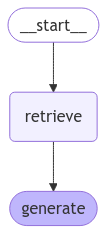

In [ ]:
# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Stream the graph
for step_result in graph.stream({"question": "Qual atriz brasileira ganhou o Globo de Ouro em 2025?"}, stream_mode="updates"):
    print(step_result)
    print("\n---\n")

{'retrieve': {'context': [Document(id='5577b271-a4a6-489b-9970-b92736bc75cc', metadata={}, page_content='\nO Brasil amanheceu com uma conquista inédita: Fernanda Torres tornou-se a primeira atriz brasileira a vencer o Globo de Ouro em 2025. Ela foi premiada por sua atuação em Ainda Estou Aqui, primeiro filme original do Globoplay, na categoria de melhor atriz em filme de drama.'), Document(id='e6007329-731c-41bd-9a37-a27a95e96015', metadata={}, page_content='\n\n\nNa cerimônia em Hollywood, Walter Salles celebrou o reconhecimento e destacou o impacto do filme no público brasileiro. Baseado no livro de Marcelo Rubens Paiva, o longa retrata a luta de Eunice Paiva para encontrar o marido, Rubens Paiva, desaparecido na ditadura militar.\n')]}}

---

{'generate': {'answer': 'A atriz brasileira que ganhou o Globo de Ouro em 2025 foi Fernanda Torres. Ela recebeu o prêmio por sua atuação no filme "Ainda Estou Aqui", primeiro filme original do Globoplay.'}}

---



In [44]:
resposta = step_result["generate"]["answer"]
print(resposta)

A atriz brasileira que ganhou o Globo de Ouro em 2025 foi Fernanda Torres. Ela recebeu o prêmio por sua atuação no filme "Ainda Estou Aqui", primeiro filme original do Globoplay.
